In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from google.colab import files
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten,Input,Conv2D, MaxPooling2D,Dropout,BatchNormalization,Reshape,Conv2DTranspose,ReLU,LeakyReLU,GaussianNoise
import random
import itertools
from sklearn.metrics import classification_report,confusion_matrix
from keras.utils import plot_model, np_utils,to_categorical
from keras.optimizers import Adam
from keras import initializers,losses
import os
from PIL import Image

plt.style.use('ggplot')

In [2]:
#https://drive.google.com/file/d/13cVJC8dhuRKdRZrRgrtPZoPFtN_UrYjV/view?usp=share_link
!gdown 13cVJC8dhuRKdRZrRgrtPZoPFtN_UrYjV

Downloading...
From: https://drive.google.com/uc?id=13cVJC8dhuRKdRZrRgrtPZoPFtN_UrYjV
To: /content/Dataset.zip
100% 807k/807k [00:00<00:00, 116MB/s]


In [5]:
!unzip Dataset.zip

Archive:  Dataset.zip
replace Dataset/Class 1/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
def load_images():

  images = []
  labels = []
  root_dir='Dataset'
  class_dirs = []
  for i in range(1,6):
    class_dirs.append('Class '+str(i))

  for i in range(1,6):
    img_dir = os.path.join(root_dir,class_dirs[i-1])
    imge_files = []
    for root, dirs, files in os.walk(img_dir):
      imge_files.extend(files)
    imge_files = sorted(imge_files)
    for img in imge_files:
      image_path = os.path.join(img_dir,img)
      image = Image.open(image_path)
      image = image.resize((28,28))
      images.append(np.array(image))
      labels.append(i)
    
  return np.array(images),np.array(labels)



In [6]:
images,labels = load_images()

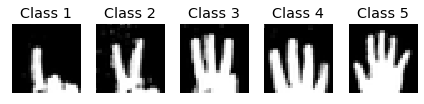

In [7]:
fig = plt.figure()
for i in range(1,6):
    plt.subplot(2, 5, i)
    x_y = images[labels == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [8]:
#pre-processing
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5


In [9]:
images.shape

(1005, 28, 28, 1)

In [10]:
#parameters
batch_size = 64
epochs = 200
noise_dim = 100
samples = 16

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(images.shape[0]).batch(batch_size)

In [ ]:
# 

In [12]:
#Generator

generator = Sequential()
generator.add(Dense(7*7*256, input_shape=(100,),kernel_initializer = initializers.RandomNormal(stddev=0.02)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))


generator.add(Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same'))
generator.add(BatchNormalization())
generator.add(ReLU(0.2))

generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same'))
generator.add(BatchNormalization())
generator.add(ReLU(0.2))


generator.add(Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2), padding='same',activation='tanh'))

In [13]:
generator.summary(line_length=150)

Model: "sequential"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 dense (Dense)                                                     (None, 12544)                                               1266944                
                                                                                                                                                      
 batch_normalization (BatchNormalization)                          (None, 12544)                                               50176                  
                                                                                                                                                      
 reshape (Reshape)                                                 (None, 

In [23]:
#Discriminator

discriminator = Sequential()
discriminator.add(Input(shape=[28,28,1]))
discriminator.add(GaussianNoise(0.1))

discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(GaussianNoise(0.1))
discriminator.add(Conv2D(128, kernel_size=(5,5), strides=(2, 2), padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

discriminator.add(GaussianNoise(0.1))
discriminator.add(Flatten())
#activation='sigmoid', we used from_logits=True in loss function so there is no need for sigmoid.
discriminator.add(Dense(1))

In [24]:
discriminator.summary(line_length=150)

Model: "sequential_5"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 gaussian_noise_11 (GaussianNoise)                                 (None, 28, 28, 1)                                           0                      
                                                                                                                                                      
 conv2d_8 (Conv2D)                                                 (None, 14, 14, 64)                                          1664                   
                                                                                                                                                      
 leaky_re_lu_8 (LeakyReLU)                                         (None

In [25]:
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [27]:
def generator_loss(fake_output):
  
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [29]:
discriminator_accuracy = tf.keras.metrics.BinaryAccuracy()
generator_accuracy = tf.keras.metrics.BinaryAccuracy()

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(x_data):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(x_data, training=True)
      fake_output = discriminator(generated_images, training=True)

      #loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      #acc
      disc_acc = discriminator_accuracy(tf.ones_like(real_output), real_output)
      gen_acc = generator_accuracy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss,disc_acc,gen_acc

In [31]:
def show_results(predictions):
  
  fig = plt.figure(figsize=(5, 5))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [32]:
def train(dataset, epochs):
  
  gen_losses = []
  disc_losses = []
  disc_acc = []
  gen_acc = []
  latent_sample = tf.random.normal([samples, noise_dim])
  for epoch in range(epochs):
    
    gen_epoch_losses = []
    disc_epoch_losses = []
    disc_epoch_acc = []
    gen_epoch_acc = []
    for image_batch in dataset:
      gen_loss,disc_loss,dac,gac = train_step(image_batch)
      gen_epoch_losses.append(gen_loss)
      disc_epoch_losses.append(disc_loss)
      disc_epoch_acc.append(dac.numpy())
      gen_epoch_acc.append(gac.numpy())

    gen_losses.append(tf.math.reduce_mean(gen_epoch_losses))
    disc_losses.append(tf.math.reduce_mean(disc_epoch_losses))
    disc_acc.append(tf.math.reduce_mean(disc_epoch_acc))
    gen_acc.append(tf.math.reduce_mean(gen_epoch_acc))
    print('epoch: {}, disc_loss: {},gen_loss: {},disc_accuracy: {},gen_accuracy: {}'.format(epoch + 1,disc_losses[-1],gen_losses[-1],disc_acc[-1],gen_acc[-1]))
    # break
    if (epoch+1) % 10 == 0:

      predictions = generator(latent_sample, training=False)
      show_results(predictions)
      
  return gen_losses,disc_losses,gen_acc,disc_acc

epoch: 1, disc_loss: 0.7375684976577759,gen_loss: 1.7458443641662598,disc_accuracy: 0.8827716112136841,gen_accuracy: 0.20757749676704407
epoch: 2, disc_loss: 0.41196951270103455,gen_loss: 3.1943893432617188,disc_accuracy: 0.9567068815231323,gen_accuracy: 0.05692177265882492
epoch: 3, disc_loss: 0.3819601535797119,gen_loss: 3.8093743324279785,disc_accuracy: 0.9698761701583862,gen_accuracy: 0.03361911326646805
epoch: 4, disc_loss: 0.3688788115978241,gen_loss: 4.320000648498535,disc_accuracy: 0.9760103225708008,gen_accuracy: 0.023943418636918068
epoch: 5, disc_loss: 0.3637441396713257,gen_loss: 4.67050313949585,disc_accuracy: 0.9798363447189331,gen_accuracy: 0.01860996149480343
epoch: 6, disc_loss: 0.3638209104537964,gen_loss: 4.6065521240234375,disc_accuracy: 0.9818291068077087,gen_accuracy: 0.01522501278668642
epoch: 7, disc_loss: 0.37313413619995117,gen_loss: 4.353816986083984,disc_accuracy: 0.983893871307373,gen_accuracy: 0.012883961200714111
epoch: 8, disc_loss: 0.3965744376182556,ge

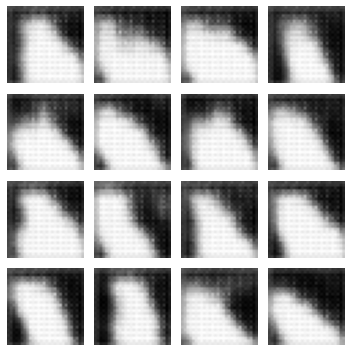

epoch: 11, disc_loss: 0.39667636156082153,gen_loss: 3.8134937286376953,disc_accuracy: 0.9773412942886353,gen_accuracy: 0.007980754598975182
epoch: 12, disc_loss: 0.4009000062942505,gen_loss: 3.735525369644165,disc_accuracy: 0.9770153760910034,gen_accuracy: 0.00728774955496192
epoch: 13, disc_loss: 0.40145203471183777,gen_loss: 3.8298583030700684,disc_accuracy: 0.976585865020752,gen_accuracy: 0.006705541163682938
epoch: 14, disc_loss: 0.4093411862850189,gen_loss: 3.8242735862731934,disc_accuracy: 0.9753100872039795,gen_accuracy: 0.006209513638168573
epoch: 15, disc_loss: 0.40592557191848755,gen_loss: 3.7881317138671875,disc_accuracy: 0.9749402403831482,gen_accuracy: 0.005781843326985836
epoch: 16, disc_loss: 0.4373774826526642,gen_loss: 3.750153064727783,disc_accuracy: 0.9733081459999084,gen_accuracy: 0.005409306846559048
epoch: 17, disc_loss: 0.4154509902000427,gen_loss: 3.9416680335998535,disc_accuracy: 0.9707272052764893,gen_accuracy: 0.0050818840973079205
epoch: 18, disc_loss: 0.428

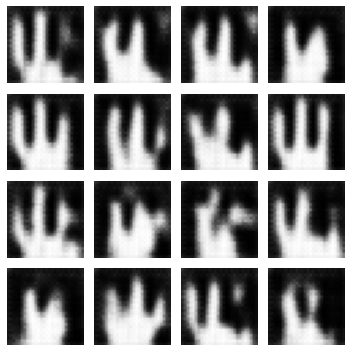

epoch: 21, disc_loss: 0.48881295323371887,gen_loss: 3.3302242755889893,disc_accuracy: 0.9665650725364685,gen_accuracy: 0.004171399399638176
epoch: 22, disc_loss: 0.4949280619621277,gen_loss: 3.1859467029571533,disc_accuracy: 0.9632914066314697,gen_accuracy: 0.0040399301797151566
epoch: 23, disc_loss: 0.5060046911239624,gen_loss: 2.973706007003784,disc_accuracy: 0.9594649076461792,gen_accuracy: 0.003982636146247387
epoch: 24, disc_loss: 0.5912248492240906,gen_loss: 2.7382657527923584,disc_accuracy: 0.9547692537307739,gen_accuracy: 0.0042594731785357
epoch: 25, disc_loss: 0.6081686615943909,gen_loss: 2.562019109725952,disc_accuracy: 0.9496821761131287,gen_accuracy: 0.0045934999361634254
epoch: 26, disc_loss: 0.6088296175003052,gen_loss: 2.4537928104400635,disc_accuracy: 0.9442657232284546,gen_accuracy: 0.005043002776801586
epoch: 27, disc_loss: 0.6730930805206299,gen_loss: 2.368438720703125,disc_accuracy: 0.9381951689720154,gen_accuracy: 0.005834270268678665
epoch: 28, disc_loss: 0.61014

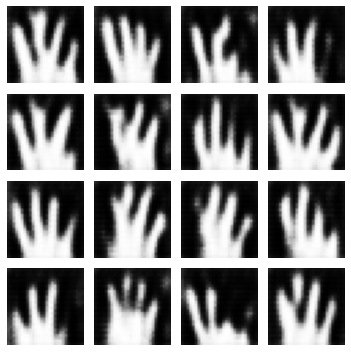

epoch: 31, disc_loss: 0.6486610174179077,gen_loss: 2.21589732170105,disc_accuracy: 0.9187456965446472,gen_accuracy: 0.006129501387476921
epoch: 32, disc_loss: 0.6336387395858765,gen_loss: 2.25482439994812,disc_accuracy: 0.9143714904785156,gen_accuracy: 0.006126512307673693
epoch: 33, disc_loss: 0.6383097171783447,gen_loss: 2.2498090267181396,disc_accuracy: 0.9104766845703125,gen_accuracy: 0.0061800116673111916
epoch: 34, disc_loss: 0.7012412548065186,gen_loss: 2.1969966888427734,disc_accuracy: 0.9060014486312866,gen_accuracy: 0.006324484944343567
epoch: 35, disc_loss: 0.7103402614593506,gen_loss: 2.116457939147949,disc_accuracy: 0.9011187553405762,gen_accuracy: 0.006612835451960564
epoch: 36, disc_loss: 0.6888388991355896,gen_loss: 2.19179368019104,disc_accuracy: 0.896196722984314,gen_accuracy: 0.007033936213701963
epoch: 37, disc_loss: 0.673799991607666,gen_loss: 2.123816967010498,disc_accuracy: 0.8922078013420105,gen_accuracy: 0.007130490615963936
epoch: 38, disc_loss: 0.717658400535

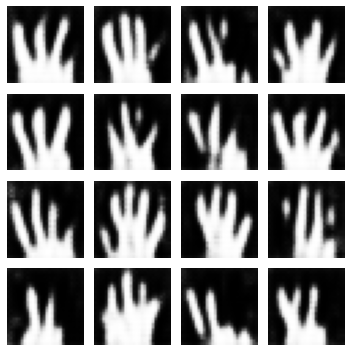

epoch: 41, disc_loss: 0.6523754596710205,gen_loss: 2.148800849914551,disc_accuracy: 0.8781263828277588,gen_accuracy: 0.007740416098386049
epoch: 42, disc_loss: 0.7277361154556274,gen_loss: 2.1561176776885986,disc_accuracy: 0.8747640252113342,gen_accuracy: 0.008015815168619156
epoch: 43, disc_loss: 0.6683601140975952,gen_loss: 2.174741268157959,disc_accuracy: 0.8719550967216492,gen_accuracy: 0.008165396749973297
epoch: 44, disc_loss: 0.6374771595001221,gen_loss: 2.1837689876556396,disc_accuracy: 0.8695781230926514,gen_accuracy: 0.00824831798672676
epoch: 45, disc_loss: 0.6989700794219971,gen_loss: 2.1818556785583496,disc_accuracy: 0.8668646216392517,gen_accuracy: 0.00847011897712946
epoch: 46, disc_loss: 0.6684793829917908,gen_loss: 2.164299488067627,disc_accuracy: 0.8642337322235107,gen_accuracy: 0.00851353071630001
epoch: 47, disc_loss: 0.6798285245895386,gen_loss: 2.2217094898223877,disc_accuracy: 0.8621567487716675,gen_accuracy: 0.008618928492069244
epoch: 48, disc_loss: 0.678080439

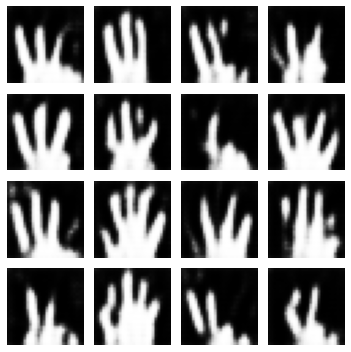

epoch: 51, disc_loss: 0.6596330404281616,gen_loss: 2.2099199295043945,disc_accuracy: 0.8535109758377075,gen_accuracy: 0.009354660287499428
epoch: 52, disc_loss: 0.6562449336051941,gen_loss: 2.2253456115722656,disc_accuracy: 0.8518157601356506,gen_accuracy: 0.009373610839247704
epoch: 53, disc_loss: 0.6716827750205994,gen_loss: 2.222227096557617,disc_accuracy: 0.8500903844833374,gen_accuracy: 0.009370559826493263
epoch: 54, disc_loss: 0.6552610397338867,gen_loss: 2.254054546356201,disc_accuracy: 0.8483688831329346,gen_accuracy: 0.009456520900130272
epoch: 55, disc_loss: 0.6584442853927612,gen_loss: 2.2497992515563965,disc_accuracy: 0.8470073938369751,gen_accuracy: 0.009538349695503712
epoch: 56, disc_loss: 0.6672307252883911,gen_loss: 2.284980297088623,disc_accuracy: 0.8456934690475464,gen_accuracy: 0.00962894968688488
epoch: 57, disc_loss: 0.6932298541069031,gen_loss: 2.337125301361084,disc_accuracy: 0.8440067768096924,gen_accuracy: 0.009769746102392673
epoch: 58, disc_loss: 0.66967874

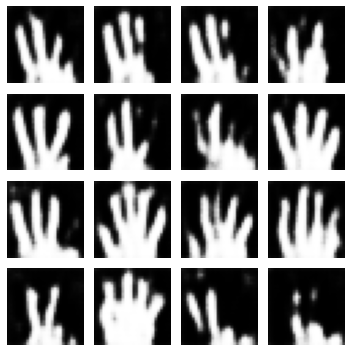

epoch: 61, disc_loss: 0.6705656051635742,gen_loss: 2.272047758102417,disc_accuracy: 0.8390071988105774,gen_accuracy: 0.010209091007709503
epoch: 62, disc_loss: 0.647718071937561,gen_loss: 2.3620893955230713,disc_accuracy: 0.8379210829734802,gen_accuracy: 0.010385286062955856
epoch: 63, disc_loss: 0.6372284889221191,gen_loss: 2.324868679046631,disc_accuracy: 0.8370836973190308,gen_accuracy: 0.010546397417783737
epoch: 64, disc_loss: 0.6706861257553101,gen_loss: 2.2981510162353516,disc_accuracy: 0.8360393047332764,gen_accuracy: 0.01064356416463852
epoch: 65, disc_loss: 0.637473464012146,gen_loss: 2.355375289916992,disc_accuracy: 0.8351472616195679,gen_accuracy: 0.010691589675843716
epoch: 66, disc_loss: 0.6321239471435547,gen_loss: 2.3347387313842773,disc_accuracy: 0.8345037698745728,gen_accuracy: 0.010725855827331543
epoch: 67, disc_loss: 0.6420466899871826,gen_loss: 2.362492561340332,disc_accuracy: 0.8336480855941772,gen_accuracy: 0.010760990902781487
epoch: 68, disc_loss: 0.6790832877

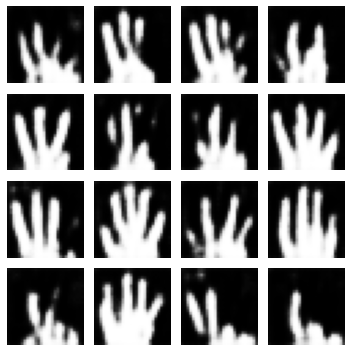

epoch: 71, disc_loss: 0.6739649176597595,gen_loss: 2.432821273803711,disc_accuracy: 0.8302661180496216,gen_accuracy: 0.011204320937395096
epoch: 72, disc_loss: 0.6366986036300659,gen_loss: 2.4002163410186768,disc_accuracy: 0.8295799493789673,gen_accuracy: 0.011335546150803566
epoch: 73, disc_loss: 0.6585894227027893,gen_loss: 2.373112201690674,disc_accuracy: 0.828754186630249,gen_accuracy: 0.011377903632819653
epoch: 74, disc_loss: 0.6538112759590149,gen_loss: 2.326267719268799,disc_accuracy: 0.8281042575836182,gen_accuracy: 0.011351101100444794
epoch: 75, disc_loss: 0.6458495855331421,gen_loss: 2.427424192428589,disc_accuracy: 0.827436625957489,gen_accuracy: 0.011366624385118484
epoch: 76, disc_loss: 0.6335994601249695,gen_loss: 2.3328146934509277,disc_accuracy: 0.8269408941268921,gen_accuracy: 0.011364790610969067
epoch: 77, disc_loss: 0.6426727175712585,gen_loss: 2.4179372787475586,disc_accuracy: 0.8265849351882935,gen_accuracy: 0.011387733742594719
epoch: 78, disc_loss: 0.688123106

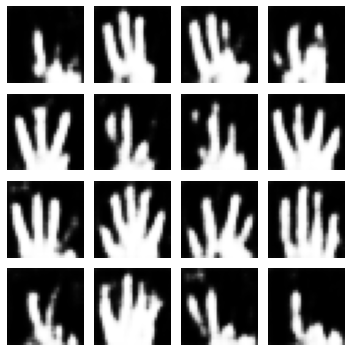

epoch: 81, disc_loss: 0.6601364612579346,gen_loss: 2.390725612640381,disc_accuracy: 0.8233485221862793,gen_accuracy: 0.011944467201828957
epoch: 82, disc_loss: 0.6413543224334717,gen_loss: 2.3992886543273926,disc_accuracy: 0.8226299285888672,gen_accuracy: 0.011991254985332489
epoch: 83, disc_loss: 0.6425991058349609,gen_loss: 2.4190664291381836,disc_accuracy: 0.8220815658569336,gen_accuracy: 0.012046350166201591
epoch: 84, disc_loss: 0.6612539887428284,gen_loss: 2.3789515495300293,disc_accuracy: 0.821527898311615,gen_accuracy: 0.012058474123477936
epoch: 85, disc_loss: 0.6542333364486694,gen_loss: 2.4004836082458496,disc_accuracy: 0.8210236430168152,gen_accuracy: 0.012142553925514221
epoch: 86, disc_loss: 0.6857891082763672,gen_loss: 2.3186588287353516,disc_accuracy: 0.8203359246253967,gen_accuracy: 0.012309549376368523
epoch: 87, disc_loss: 0.6415815353393555,gen_loss: 2.442084312438965,disc_accuracy: 0.8198240995407104,gen_accuracy: 0.012318998575210571
epoch: 88, disc_loss: 0.653441

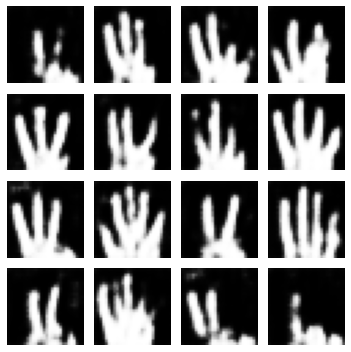

epoch: 91, disc_loss: 0.6689033508300781,gen_loss: 2.300811290740967,disc_accuracy: 0.8181942105293274,gen_accuracy: 0.012550629675388336
epoch: 92, disc_loss: 0.6338300704956055,gen_loss: 2.41202449798584,disc_accuracy: 0.817834198474884,gen_accuracy: 0.01263359747827053
epoch: 93, disc_loss: 0.6410331130027771,gen_loss: 2.3668885231018066,disc_accuracy: 0.8174797296524048,gen_accuracy: 0.01265672966837883
epoch: 94, disc_loss: 0.6594945192337036,gen_loss: 2.302466869354248,disc_accuracy: 0.8170675039291382,gen_accuracy: 0.012640196830034256
epoch: 95, disc_loss: 0.6793555021286011,gen_loss: 2.329254150390625,disc_accuracy: 0.8165792226791382,gen_accuracy: 0.012685158289968967
epoch: 96, disc_loss: 0.7029139995574951,gen_loss: 2.4050333499908447,disc_accuracy: 0.8158136010169983,gen_accuracy: 0.012832241132855415
epoch: 97, disc_loss: 0.6987876892089844,gen_loss: 2.328354835510254,disc_accuracy: 0.8152012825012207,gen_accuracy: 0.012916220352053642
epoch: 98, disc_loss: 0.657504677772

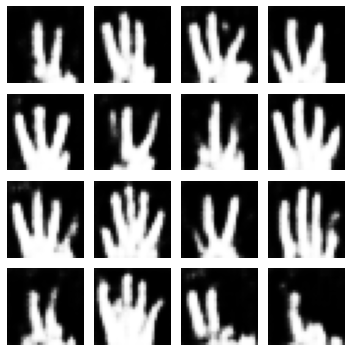

epoch: 101, disc_loss: 0.6894121766090393,gen_loss: 2.3396801948547363,disc_accuracy: 0.8133035898208618,gen_accuracy: 0.013189120218157768
epoch: 102, disc_loss: 0.6872219443321228,gen_loss: 2.2987966537475586,disc_accuracy: 0.8128326535224915,gen_accuracy: 0.013272666372358799
epoch: 103, disc_loss: 0.6961127519607544,gen_loss: 2.3326594829559326,disc_accuracy: 0.8120313882827759,gen_accuracy: 0.013410480692982674
epoch: 104, disc_loss: 0.6727670431137085,gen_loss: 2.3343963623046875,disc_accuracy: 0.8115570545196533,gen_accuracy: 0.013479595072567463
epoch: 105, disc_loss: 0.6474616527557373,gen_loss: 2.3528451919555664,disc_accuracy: 0.8111203908920288,gen_accuracy: 0.013567893765866756
epoch: 106, disc_loss: 0.6711152195930481,gen_loss: 2.293022394180298,disc_accuracy: 0.8108465671539307,gen_accuracy: 0.013572976924479008
epoch: 107, disc_loss: 0.7078486680984497,gen_loss: 2.364215135574341,disc_accuracy: 0.8101087808609009,gen_accuracy: 0.013741092756390572
epoch: 108, disc_loss:

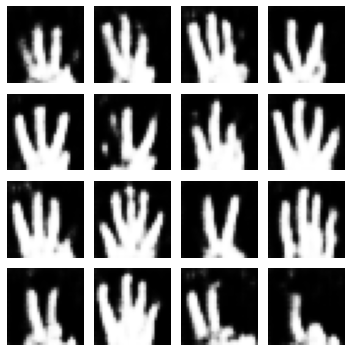

epoch: 111, disc_loss: 0.7096694707870483,gen_loss: 2.303807258605957,disc_accuracy: 0.8079662322998047,gen_accuracy: 0.013985374942421913
epoch: 112, disc_loss: 0.6898087859153748,gen_loss: 2.27348256111145,disc_accuracy: 0.8073900938034058,gen_accuracy: 0.014091603457927704
epoch: 113, disc_loss: 0.6759822368621826,gen_loss: 2.295140266418457,disc_accuracy: 0.8069037199020386,gen_accuracy: 0.014175742864608765
epoch: 114, disc_loss: 0.732213020324707,gen_loss: 2.338430643081665,disc_accuracy: 0.8064993619918823,gen_accuracy: 0.014294294640421867
epoch: 115, disc_loss: 0.7385238409042358,gen_loss: 2.229682207107544,disc_accuracy: 0.8057423233985901,gen_accuracy: 0.014463676139712334
epoch: 116, disc_loss: 0.6915141344070435,gen_loss: 2.2612602710723877,disc_accuracy: 0.8050556182861328,gen_accuracy: 0.014495985582470894
epoch: 117, disc_loss: 0.659274697303772,gen_loss: 2.3216447830200195,disc_accuracy: 0.8047729730606079,gen_accuracy: 0.014487924054265022
epoch: 118, disc_loss: 0.713

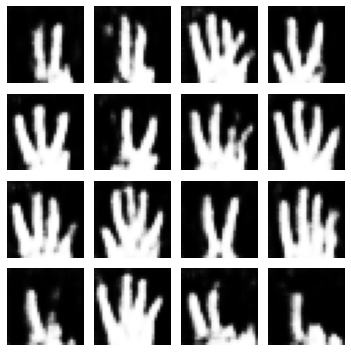

epoch: 121, disc_loss: 0.7062908411026001,gen_loss: 2.2142302989959717,disc_accuracy: 0.8025112748146057,gen_accuracy: 0.01491502858698368
epoch: 122, disc_loss: 0.7070214748382568,gen_loss: 2.2851970195770264,disc_accuracy: 0.8020449280738831,gen_accuracy: 0.014994673430919647
epoch: 123, disc_loss: 0.6910221576690674,gen_loss: 2.265869379043579,disc_accuracy: 0.801586389541626,gen_accuracy: 0.015021270141005516
epoch: 124, disc_loss: 0.6550160646438599,gen_loss: 2.312145471572876,disc_accuracy: 0.8011993169784546,gen_accuracy: 0.015035530552268028
epoch: 125, disc_loss: 0.6790622472763062,gen_loss: 2.2739036083221436,disc_accuracy: 0.8008890151977539,gen_accuracy: 0.015042722225189209
epoch: 126, disc_loss: 0.7018153667449951,gen_loss: 2.282243013381958,disc_accuracy: 0.8004693984985352,gen_accuracy: 0.01512998342514038
epoch: 127, disc_loss: 0.7247451543807983,gen_loss: 2.2124640941619873,disc_accuracy: 0.8000599145889282,gen_accuracy: 0.01520763523876667
epoch: 128, disc_loss: 0.71

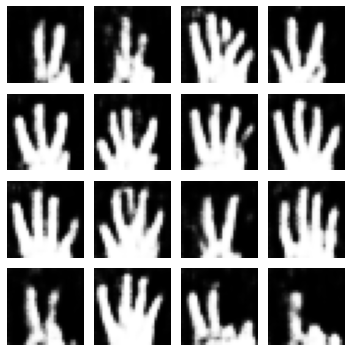

epoch: 131, disc_loss: 0.7056716084480286,gen_loss: 2.255251884460449,disc_accuracy: 0.7980252504348755,gen_accuracy: 0.015584241598844528
epoch: 132, disc_loss: 0.700053334236145,gen_loss: 2.2358055114746094,disc_accuracy: 0.7975689172744751,gen_accuracy: 0.015654191374778748
epoch: 133, disc_loss: 0.7479625344276428,gen_loss: 2.2280430793762207,disc_accuracy: 0.7968810796737671,gen_accuracy: 0.015769056975841522
epoch: 134, disc_loss: 0.7325149774551392,gen_loss: 2.2028703689575195,disc_accuracy: 0.7963679432868958,gen_accuracy: 0.015887759625911713
epoch: 135, disc_loss: 0.7383876442909241,gen_loss: 2.140845775604248,disc_accuracy: 0.7958595752716064,gen_accuracy: 0.015982437878847122
epoch: 136, disc_loss: 0.7593414783477783,gen_loss: 2.2164382934570312,disc_accuracy: 0.7952060699462891,gen_accuracy: 0.016141043975949287
epoch: 137, disc_loss: 0.7193034887313843,gen_loss: 2.2717928886413574,disc_accuracy: 0.7947819828987122,gen_accuracy: 0.016187790781259537
epoch: 138, disc_loss: 

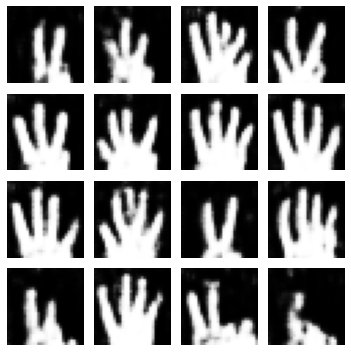

epoch: 141, disc_loss: 0.711301326751709,gen_loss: 2.194504737854004,disc_accuracy: 0.7935822606086731,gen_accuracy: 0.01642192341387272
epoch: 142, disc_loss: 0.7324596047401428,gen_loss: 2.1907241344451904,disc_accuracy: 0.7931210994720459,gen_accuracy: 0.016530532389879227
epoch: 143, disc_loss: 0.7159279584884644,gen_loss: 2.2362756729125977,disc_accuracy: 0.7926596403121948,gen_accuracy: 0.0165996216237545
epoch: 144, disc_loss: 0.6957669854164124,gen_loss: 2.2055108547210693,disc_accuracy: 0.7922025918960571,gen_accuracy: 0.016648123040795326
epoch: 145, disc_loss: 0.6868332028388977,gen_loss: 2.2436282634735107,disc_accuracy: 0.7919389009475708,gen_accuracy: 0.016645681113004684
epoch: 146, disc_loss: 0.7253124713897705,gen_loss: 2.2549586296081543,disc_accuracy: 0.7915277481079102,gen_accuracy: 0.016759859398007393
epoch: 147, disc_loss: 0.7091993093490601,gen_loss: 2.2073111534118652,disc_accuracy: 0.7911780476570129,gen_accuracy: 0.016789209097623825
epoch: 148, disc_loss: 0.

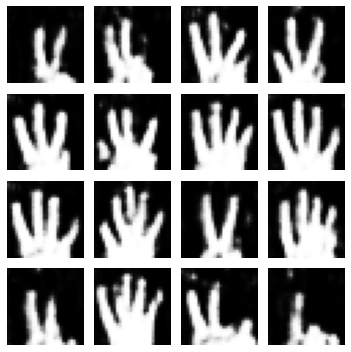

epoch: 151, disc_loss: 0.7454389929771423,gen_loss: 2.1534667015075684,disc_accuracy: 0.7899242639541626,gen_accuracy: 0.017004724591970444
epoch: 152, disc_loss: 0.6908227801322937,gen_loss: 2.2059412002563477,disc_accuracy: 0.7894985675811768,gen_accuracy: 0.017068617045879364
epoch: 153, disc_loss: 0.7227489948272705,gen_loss: 2.1873903274536133,disc_accuracy: 0.7891973257064819,gen_accuracy: 0.017070699483156204
epoch: 154, disc_loss: 0.7222045063972473,gen_loss: 2.2185771465301514,disc_accuracy: 0.788729727268219,gen_accuracy: 0.017139621078968048
epoch: 155, disc_loss: 0.7296726703643799,gen_loss: 2.1884238719940186,disc_accuracy: 0.7882738709449768,gen_accuracy: 0.017230935394763947
epoch: 156, disc_loss: 0.7195680141448975,gen_loss: 2.2285258769989014,disc_accuracy: 0.7879462242126465,gen_accuracy: 0.017262157052755356
epoch: 157, disc_loss: 0.6997318863868713,gen_loss: 2.239396572113037,disc_accuracy: 0.7876139879226685,gen_accuracy: 0.01733829453587532
epoch: 158, disc_loss: 

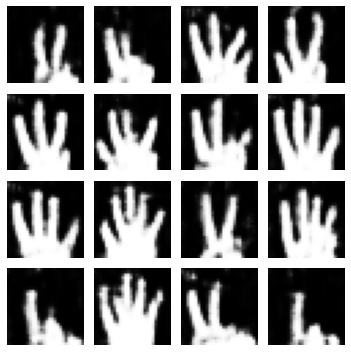

epoch: 161, disc_loss: 0.7588422298431396,gen_loss: 2.2542800903320312,disc_accuracy: 0.7858866453170776,gen_accuracy: 0.017728598788380623
epoch: 162, disc_loss: 0.7052061557769775,gen_loss: 2.198089838027954,disc_accuracy: 0.7855615615844727,gen_accuracy: 0.017866019159555435
epoch: 163, disc_loss: 0.7478029131889343,gen_loss: 2.167163848876953,disc_accuracy: 0.7852093577384949,gen_accuracy: 0.017931833863258362
epoch: 164, disc_loss: 0.7270861864089966,gen_loss: 2.227957010269165,disc_accuracy: 0.7847476005554199,gen_accuracy: 0.018024850636720657
epoch: 165, disc_loss: 0.7551302909851074,gen_loss: 2.1521005630493164,disc_accuracy: 0.7843202948570251,gen_accuracy: 0.018114842474460602
epoch: 166, disc_loss: 0.7447463274002075,gen_loss: 2.225691795349121,disc_accuracy: 0.783879280090332,gen_accuracy: 0.01821155846118927
epoch: 167, disc_loss: 0.7179197669029236,gen_loss: 2.1065187454223633,disc_accuracy: 0.7835193872451782,gen_accuracy: 0.018245894461870193
epoch: 168, disc_loss: 0.7

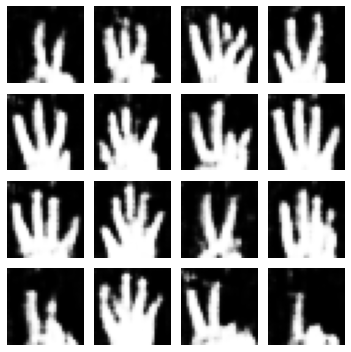

epoch: 171, disc_loss: 0.7517637014389038,gen_loss: 2.158005952835083,disc_accuracy: 0.7822930812835693,gen_accuracy: 0.018466077744960785
epoch: 172, disc_loss: 0.7671722173690796,gen_loss: 2.134847402572632,disc_accuracy: 0.7818036079406738,gen_accuracy: 0.018569394946098328
epoch: 173, disc_loss: 0.7122968435287476,gen_loss: 2.197530508041382,disc_accuracy: 0.7814083099365234,gen_accuracy: 0.018621355295181274
epoch: 174, disc_loss: 0.7288728356361389,gen_loss: 2.1896963119506836,disc_accuracy: 0.7810102105140686,gen_accuracy: 0.018663879483938217
epoch: 175, disc_loss: 0.7239391207695007,gen_loss: 2.1823649406433105,disc_accuracy: 0.7807530164718628,gen_accuracy: 0.018702423200011253
epoch: 176, disc_loss: 0.7012476921081543,gen_loss: 2.2352137565612793,disc_accuracy: 0.780544102191925,gen_accuracy: 0.01873357594013214
epoch: 177, disc_loss: 0.7014992833137512,gen_loss: 2.2461743354797363,disc_accuracy: 0.7803454399108887,gen_accuracy: 0.01877301186323166
epoch: 178, disc_loss: 0.7

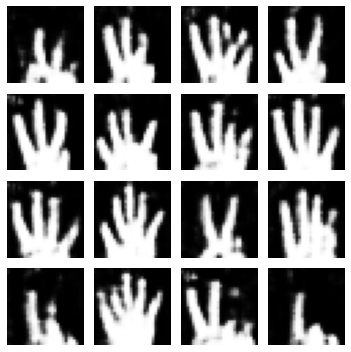

epoch: 181, disc_loss: 0.7258678674697876,gen_loss: 2.2150321006774902,disc_accuracy: 0.7790507078170776,gen_accuracy: 0.01904269866645336
epoch: 182, disc_loss: 0.7391120195388794,gen_loss: 2.243417501449585,disc_accuracy: 0.778773844242096,gen_accuracy: 0.019094137474894524
epoch: 183, disc_loss: 0.7240617275238037,gen_loss: 2.2213363647460938,disc_accuracy: 0.7784884572029114,gen_accuracy: 0.019128626212477684
epoch: 184, disc_loss: 0.7004586458206177,gen_loss: 2.278770923614502,disc_accuracy: 0.778274655342102,gen_accuracy: 0.019146794453263283
epoch: 185, disc_loss: 0.7195031642913818,gen_loss: 2.2101449966430664,disc_accuracy: 0.7779300212860107,gen_accuracy: 0.019175363704562187
epoch: 186, disc_loss: 0.7195034027099609,gen_loss: 2.2165369987487793,disc_accuracy: 0.7776801586151123,gen_accuracy: 0.019204232841730118
epoch: 187, disc_loss: 0.7204257249832153,gen_loss: 2.2714972496032715,disc_accuracy: 0.777498185634613,gen_accuracy: 0.019262265413999557
epoch: 188, disc_loss: 0.7

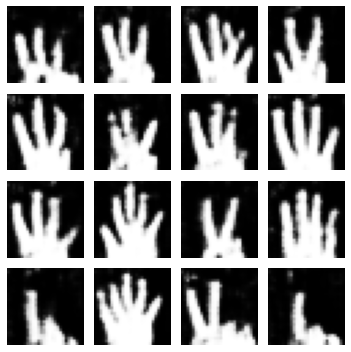

epoch: 191, disc_loss: 0.7247099876403809,gen_loss: 2.2242627143859863,disc_accuracy: 0.7766183614730835,gen_accuracy: 0.019378410652279854
epoch: 192, disc_loss: 0.6864467263221741,gen_loss: 2.2887401580810547,disc_accuracy: 0.7763965725898743,gen_accuracy: 0.019436579197645187
epoch: 193, disc_loss: 0.6984660029411316,gen_loss: 2.3145248889923096,disc_accuracy: 0.776272714138031,gen_accuracy: 0.019460543990135193
epoch: 194, disc_loss: 0.688861072063446,gen_loss: 2.2943170070648193,disc_accuracy: 0.7761038541793823,gen_accuracy: 0.019467851147055626
epoch: 195, disc_loss: 0.7023946642875671,gen_loss: 2.2318625450134277,disc_accuracy: 0.7759575247764587,gen_accuracy: 0.01947164162993431
epoch: 196, disc_loss: 0.7029420137405396,gen_loss: 2.331469774246216,disc_accuracy: 0.7757465839385986,gen_accuracy: 0.019482538104057312
epoch: 197, disc_loss: 0.6799795627593994,gen_loss: 2.239905834197998,disc_accuracy: 0.7756721377372742,gen_accuracy: 0.019475668668746948
epoch: 198, disc_loss: 0.

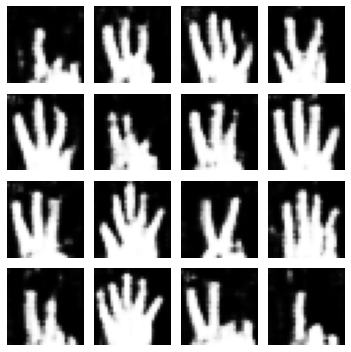

In [33]:
gen_losses,disc_losses,gen_acc,disc_acc = train(train_dataset, epochs)

In [34]:
def plot_metrics(hist,title,metric):
  fig , ax = plt.subplots(figsize = (10,8))
  ax.plot(hist[0])
  ax.plot(hist[1])
  ax.legend(['Discriminator', 'Generator']) 
  ax.set_xlabel('Epoch')
  ax.set_ylabel(metric)
  ax.set_title(title)
  plt.show()

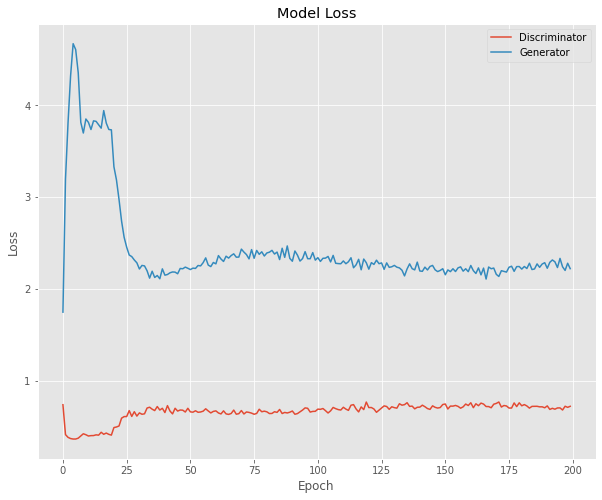

In [35]:
plot_metrics([disc_losses,gen_losses],'Model Loss','Loss')

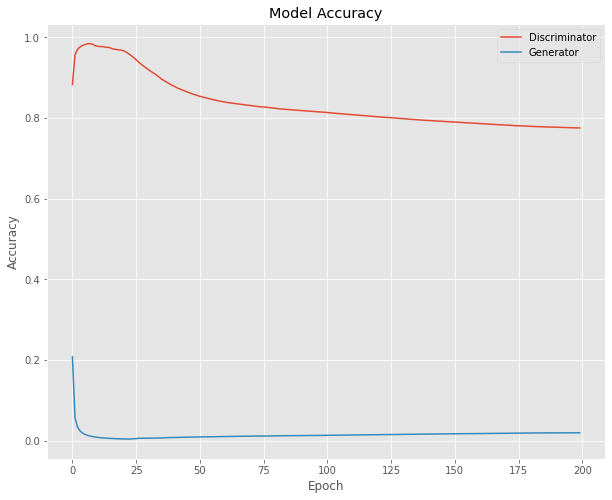

In [36]:
plot_metrics([disc_acc,gen_acc],'Model Accuracy','Accuracy')